# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

The dataset covers 17 marketing campaigns conducted between May 2008 and November 2010, comprising a total of 79,354 customer contacts. In these phone campaigns, customers were offered an attractive long-term deposit product with competitive interest rates. For each contact, numerous attributes were recorded, along with an indicator of whether the offer resulted in a successful subscription (the target variable). Across the entire dataset, 6,499 contacts subscribed, corresponding to a success rate of approximately 8%.

In [218]:
import pandas as pd
import numpy as np

# data viz
import seaborn as sns
import matplotlib.pyplot as plt
#plt.style.use("fivethirtyeight") # styling your charts

# pre-processing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# modeling
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier

# validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

print("All modules loaded")

All modules loaded


### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [219]:
import pandas as pd

In [220]:
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [221]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [222]:
df.shape

(41188, 21)

In [223]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [224]:
df.y.value_counts(normalize=True).round(3)

y
no     0.887
yes    0.113
Name: proportion, dtype: float64

In [225]:
df.select_dtypes(include = "object").agg(["nunique"])

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,y
nunique,12,4,8,3,3,3,2,10,5,3,2


In [226]:
df['education'].value_counts()

education
university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: count, dtype: int64

In [227]:
df.select_dtypes(include = "object").agg(["nunique"]).sum(axis = 1)

nunique    55
dtype: int64

### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



### Data checks

## Nulls

In [261]:
# Step 1: Check nulls
df.isnull().sum()

age                     0
job                     0
marital                 0
education               0
default                 0
housing                 0
loan                    0
contact                 0
month                   0
day_of_week             0
duration                0
campaign                0
pdays                   0
previous                0
poutcome                0
emp.var.rate            0
cons.price.idx          0
cons.conf.idx           0
euribor3m               0
nr.employed             0
y                       0
previously_contacted    0
age_z                   0
duration_z              0
dtype: int64

## Missing Values

In [229]:
# Step 2: Impute missing values
unknown_counts = (df == "unknown").sum()
unknown_counts

age                  0
job                330
marital             80
education         1731
default           8597
housing            990
loan               990
contact              0
month                0
day_of_week          0
duration             0
campaign             0
pdays                0
previous             0
poutcome             0
emp.var.rate         0
cons.price.idx       0
cons.conf.idx        0
euribor3m            0
nr.employed          0
y                    0
dtype: int64

In [230]:
(df == "unknown").sum() / len(df) * 100

age                0.000000
job                0.801204
marital            0.194231
education          4.202680
default           20.872584
housing            2.403613
loan               2.403613
contact            0.000000
month              0.000000
day_of_week        0.000000
duration           0.000000
campaign           0.000000
pdays              0.000000
previous           0.000000
poutcome           0.000000
emp.var.rate       0.000000
cons.price.idx     0.000000
cons.conf.idx      0.000000
euribor3m          0.000000
nr.employed        0.000000
y                  0.000000
dtype: float64

In [231]:
# marital is only 80, replace with most common marital status
marital_mode_0 = df.loc[df['marital'] != 'unknown', 'marital'].mode()[0]
marital_mode_0

'married'

In [232]:
# married is most common so replace unknowns with 'married'
df.loc[df['marital'] == 'unknown', 'marital'] = marital_mode_0
unknown_counts = (df == "unknown").sum()
unknown_counts

age                  0
job                330
marital              0
education         1731
default           8597
housing            990
loan               990
contact              0
month                0
day_of_week          0
duration             0
campaign             0
pdays                0
previous             0
poutcome             0
emp.var.rate         0
cons.price.idx       0
cons.conf.idx        0
euribor3m            0
nr.employed          0
y                    0
dtype: int64

In [233]:
df['education'].value_counts()

education
university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: count, dtype: int64

In [234]:
df['default'].value_counts()

default
no         32588
unknown     8597
yes            3
Name: count, dtype: int64

## Duplicates

In [235]:
# Step 3 check duplicates and remove
df.duplicated().any()

np.True_

In [236]:
df.drop_duplicates(inplace=True)

## Outliers

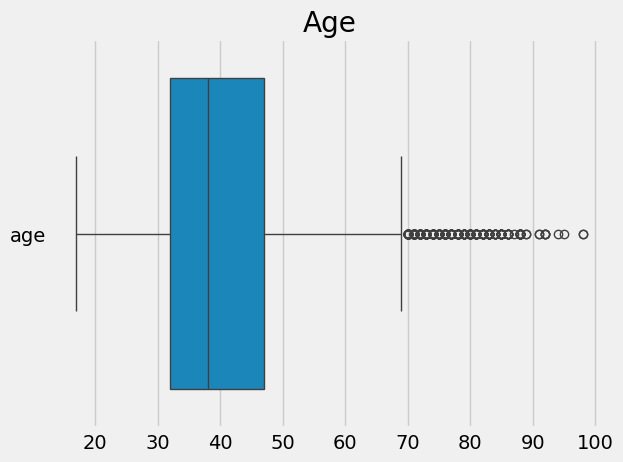

In [237]:
# Step 4 - check for outliers - check numerical features
# check for unrealistic age
# duration - heavily skewed, i.e. calls lasting a long time
sns.boxplot(data=df[['age']], orient='h')
plt.title("Age")
plt.show()

In [238]:
len(df[df['age'] > 70])

421

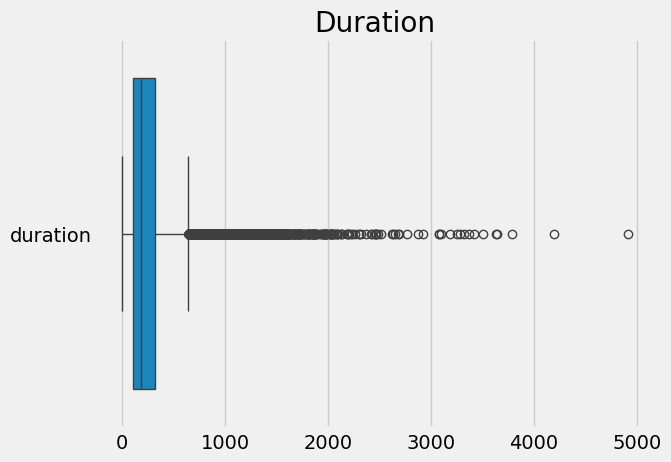

In [239]:
sns.boxplot(data=df[['duration']], orient='h')
plt.title("Duration")
plt.show()

In [240]:
len(df[df['duration'] > 1000])

956

Age and duration are valid. There is 956 entries with calls > than 1000 meaning these customers most likely subscribed, and age beyond 70 are still valid because this 
ages range could signify a higher chance of subscribing. 

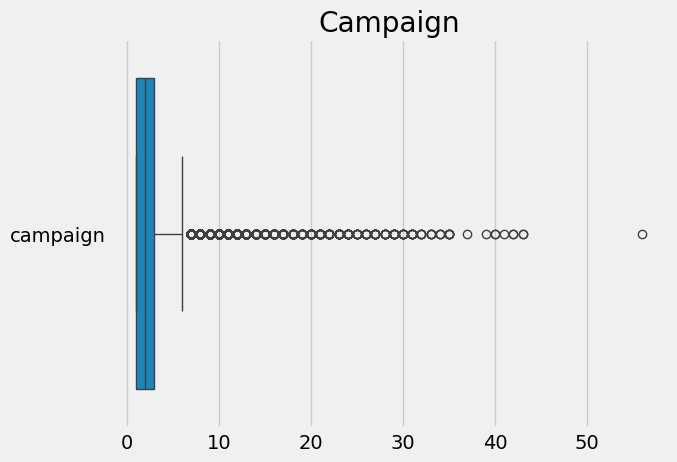

In [241]:
sns.boxplot(data=df[['campaign']], orient='h')
plt.title("Campaign")
plt.show()

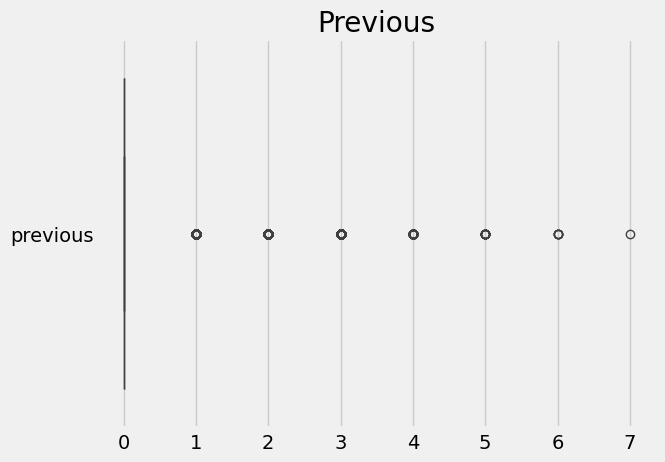

In [242]:
sns.boxplot(data=df[['previous']], orient='h')
plt.title("Previous")
plt.show()

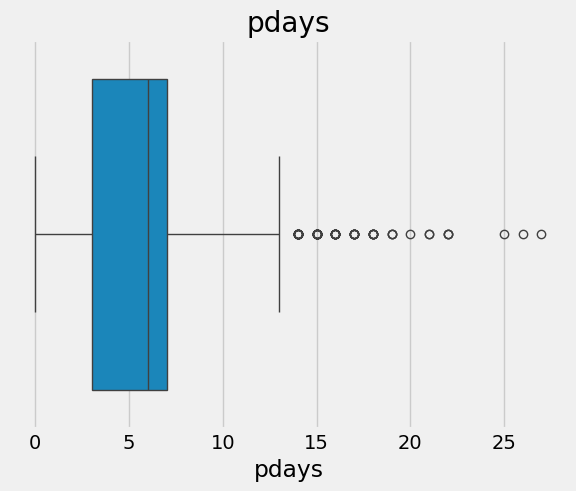

In [243]:
sns.boxplot(data=df.loc[df['pdays'] < 999, 'pdays'], orient='h')
plt.title("pdays")
plt.show()

We have to handle pdays a little different because having data for never contacted clients is encoded as 999, which doesn’t represent a real number of days but rather a special category. If we leave it as-is, it will distort the distribution and mislead models into treating 999 as an actual large value. Let's create a new binary features previously_contacted to capture if the client was previously contacted.

In [244]:
df['previously_contacted'] = (df['pdays'] == 999).astype(int)
df.loc[df['pdays'] == 999, 'pdays'] = 0
df.sample(5)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,previously_contacted
17135,51,technician,divorced,professional.course,no,no,no,cellular,jul,fri,...,0,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no,1
26230,46,unemployed,married,basic.6y,no,yes,no,cellular,nov,thu,...,0,0,nonexistent,-0.1,93.200,-42.0,4.076,5195.8,no,1
4167,52,services,divorced,high.school,no,no,no,telephone,may,mon,...,0,0,nonexistent,1.1,93.994,-36.4,4.858,5191.0,yes,1
5393,45,blue-collar,married,illiterate,unknown,no,yes,telephone,may,fri,...,0,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,1
39052,70,retired,married,basic.4y,no,no,no,cellular,dec,wed,...,0,0,nonexistent,-3.0,92.713,-33.0,0.715,5023.5,yes,1


There are outliers is age, duration, campaign and pdays which we will leave in for tree based models, but SVM, logistic regression and KNN are all sensitive to outliers so we will remove them for all linear models.

### Removing outliers using Z-score for linear models

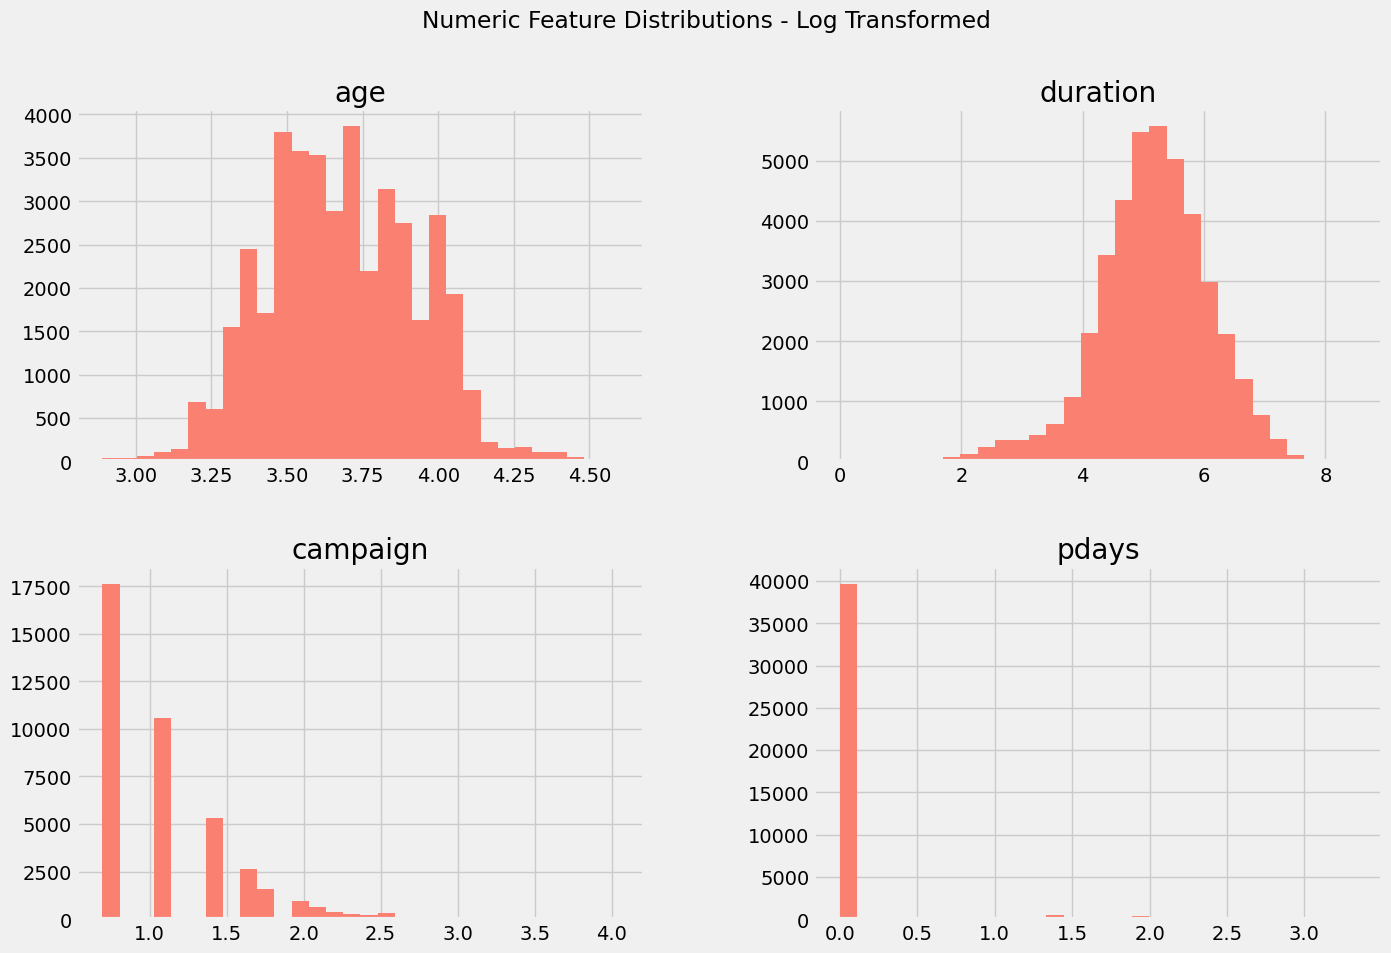

In [245]:
# Apply log transform (adding 1 to avoid log(0))
df_log = df[['age', 'duration', 'campaign', 'pdays']].apply(lambda x: np.log(x + 1))

# Plot log-transformed distributions
df_log.hist(figsize=(15, 10), bins=30, color='salmon')
plt.suptitle('Numeric Feature Distributions - Log Transformed')
plt.show()

In [246]:
# age and duration have a normal distribution which we can use z-score to remove outliers.
df['age_z'] = (df['age'] - df['age'].mean()) / df['age'].std()
df['duration_z'] = (df['duration'] - df['duration'].mean()) / df['duration'].std()
df.sample(5)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,previously_contacted,age_z,duration_z
20567,31,technician,single,university.degree,no,no,no,cellular,aug,tue,...,nonexistent,1.4,93.444,-36.1,4.966,5228.1,no,1,-0.865951,0.581107
3547,25,services,divorced,basic.4y,no,yes,no,telephone,may,fri,...,nonexistent,1.1,93.994,-36.4,4.859,5191.0,no,1,-1.441729,1.321547
15140,49,admin.,married,high.school,unknown,yes,no,cellular,jul,thu,...,nonexistent,1.4,93.918,-42.7,4.958,5228.1,no,1,0.861383,-0.722376
19555,44,admin.,divorced,university.degree,no,yes,no,cellular,aug,thu,...,nonexistent,1.4,93.444,-36.1,4.968,5228.1,no,1,0.381568,-0.344443
22905,46,admin.,married,university.degree,unknown,no,yes,cellular,aug,mon,...,nonexistent,1.4,93.444,-36.1,4.965,5228.1,no,1,0.573494,-0.286596


In [247]:
age_outliers = df[abs(df['age_z']) > 3]
duration_outliers = df[abs(df['duration_z']) > 3]
print("Age outliers:", len(age_outliers))
print("Duration outliers:", len(duration_outliers))

Age outliers: 369
Duration outliers: 861


In [248]:
df_linear_models = df[(df['age_z'].abs() < 3) & (df['duration_z'].abs() < 3)]
age_outliers = df_linear_models[abs(df_linear_models['age_z']) > 3]
duration_outliers = df_linear_models[abs(df_linear_models['duration_z']) > 3]
print("Age outliers:", len(age_outliers))
print("Duration outliers:", len(duration_outliers))

Age outliers: 0
Duration outliers: 0


In [249]:
df_linear_models[['campaign', 'pdays']].describe()

,campaign,pdays
count,39951.000000,39951.000000
mean,2.572526,0.212535
std,2.786008,1.327050
min,1.000000,0.000000
25%,1.000000,0.000000
50%,2.000000,0.000000
75%,3.000000,0.000000
max,56.000000,27.000000


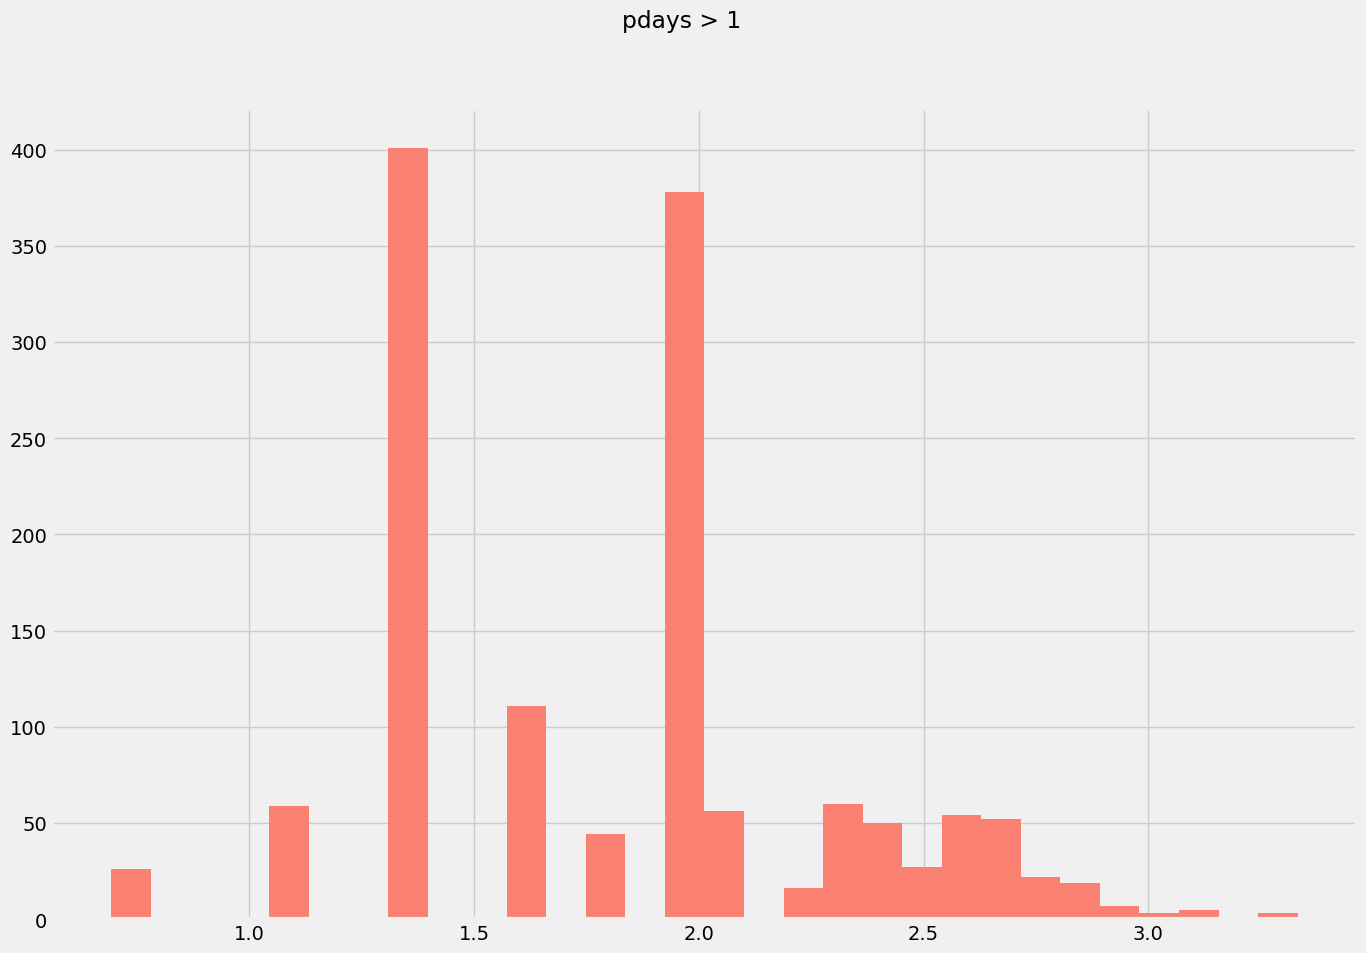

In [253]:
pdays_log_above_1 = df_linear_models.loc[df_linear_models['pdays'] > 0, 'pdays'].apply(lambda x: np.log(x + 1))
pdays_log_above_1.hist(figsize=(15, 10), bins=30, color='salmon')
plt.suptitle('pdays > 1')
plt.show()

In [254]:
# pdays is not normally distributed but since values left are bound at 0 we can just remove a percential off the top
pdays_95_percentile = df_linear_models.loc[df_linear_models['pdays'] > 0, 'pdays'].quantile(0.95)   # 95th percentile
print('pdays 95th percentile', pdays_95_percentile)
df_linear_models = df_linear_models[df_linear_models['pdays'] <= pdays_95_percentile]

pdays 95th percentile 14.0


In [255]:
df_linear_models['pdays'].value_counts()

pdays
0     38558
3       401
6       378
4       111
9        60
2        59
7        56
12       54
10       50
5        44
13       33
11       27
1        26
14       19
8        16
Name: count, dtype: int64

In [260]:
df_linear_models['campaign_z'] = (df_linear_models['campaign'] - df_linear_models['campaign'].mean()) / df['campaign'].std()
campaign_outliers = df_linear_models[abs(df_linear_models['campaign_z']) > 3]
print("Campaign outliers:", len(campaign_outliers))
df_linear_models = df_linear_models[df_linear_models['campaign_z'].abs() < 3]

Campaign outliers: 0
Campaign outliers: 0


### EDA
Now outliers are all removed we can start our exploratory data analysis

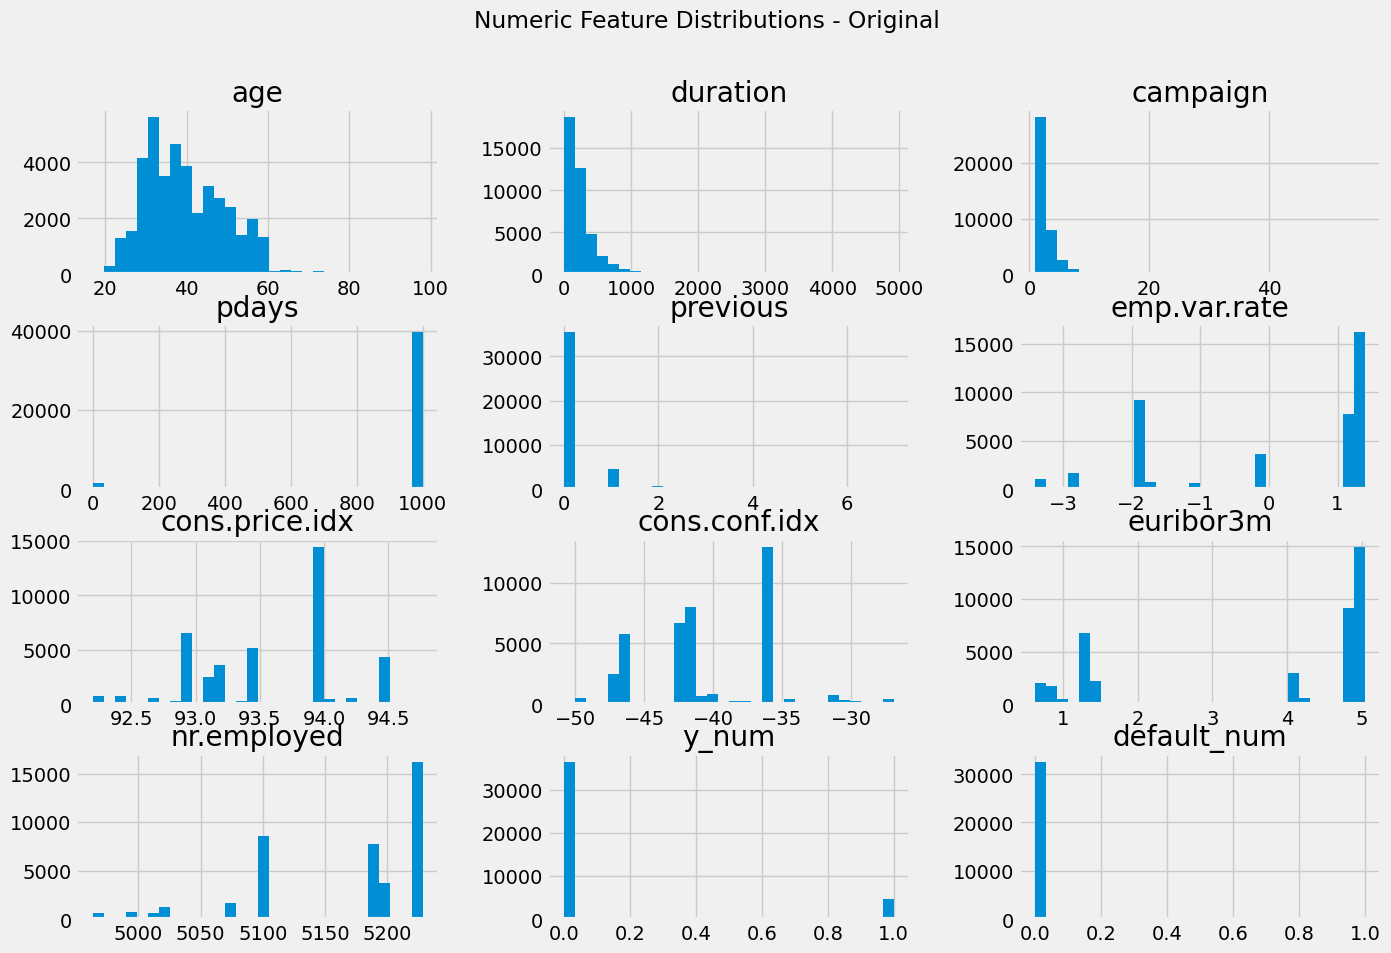

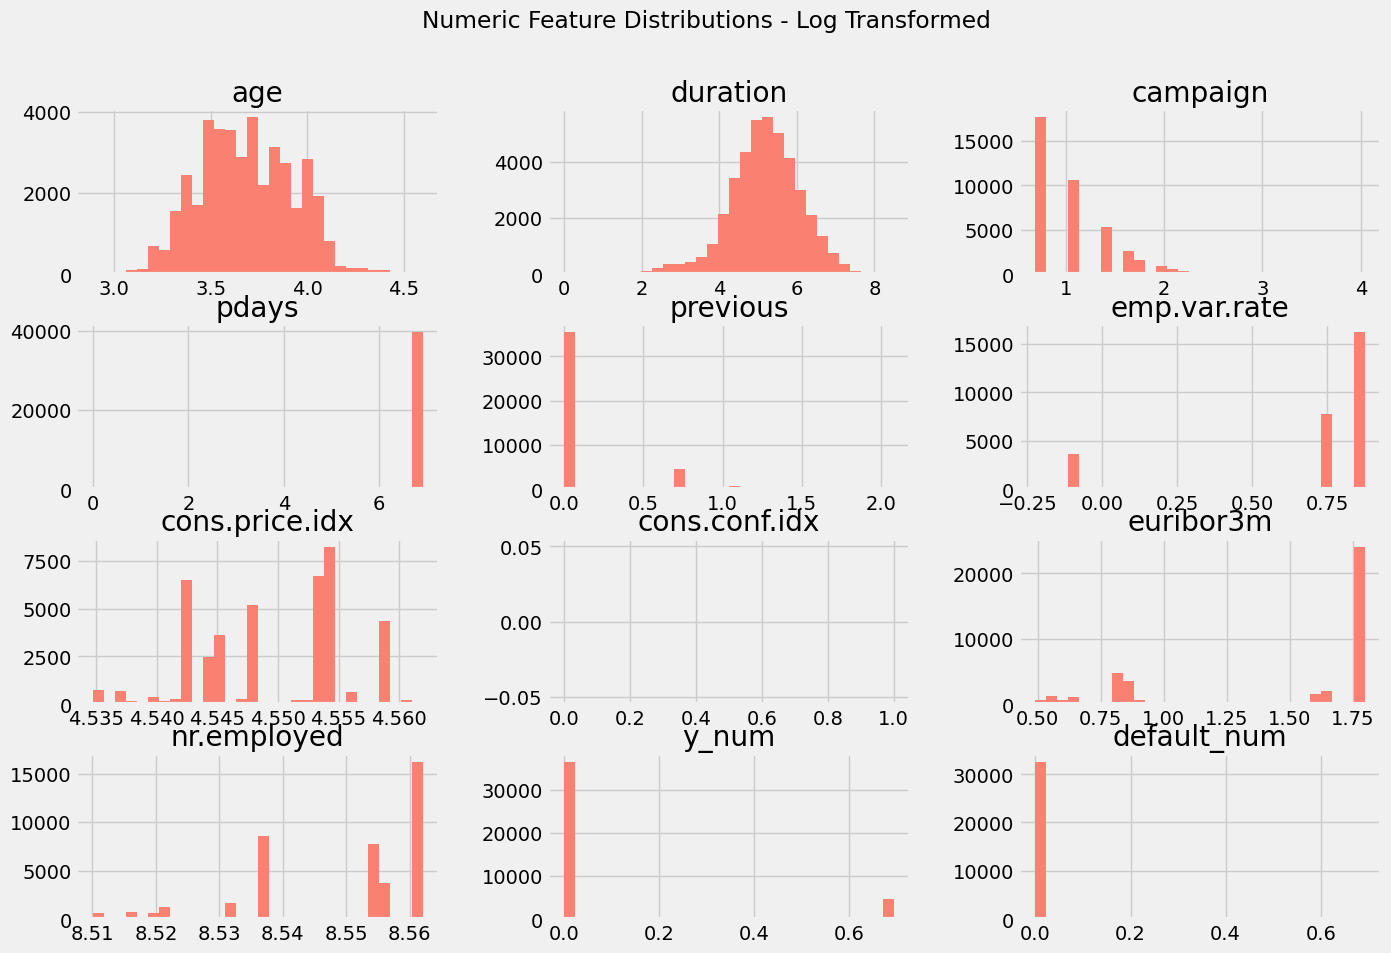

In [111]:
# Step check distribution - job and education I suspect to be largely impact success rate

# Select numeric columns
num_cols = df.select_dtypes(include=[np.number]).columns

# Apply log transform (adding 1 to avoid log(0))
df_log = df[num_cols].apply(lambda x: np.log(x + 1))

# Plot original distributions
df[num_cols].hist(figsize=(15, 10), bins=30)
plt.suptitle('Numeric Feature Distributions - Original')
plt.show()

# Plot log-transformed distributions
df_log.hist(figsize=(15, 10), bins=30, color='salmon')
plt.suptitle('Numeric Feature Distributions - Log Transformed')
plt.show()

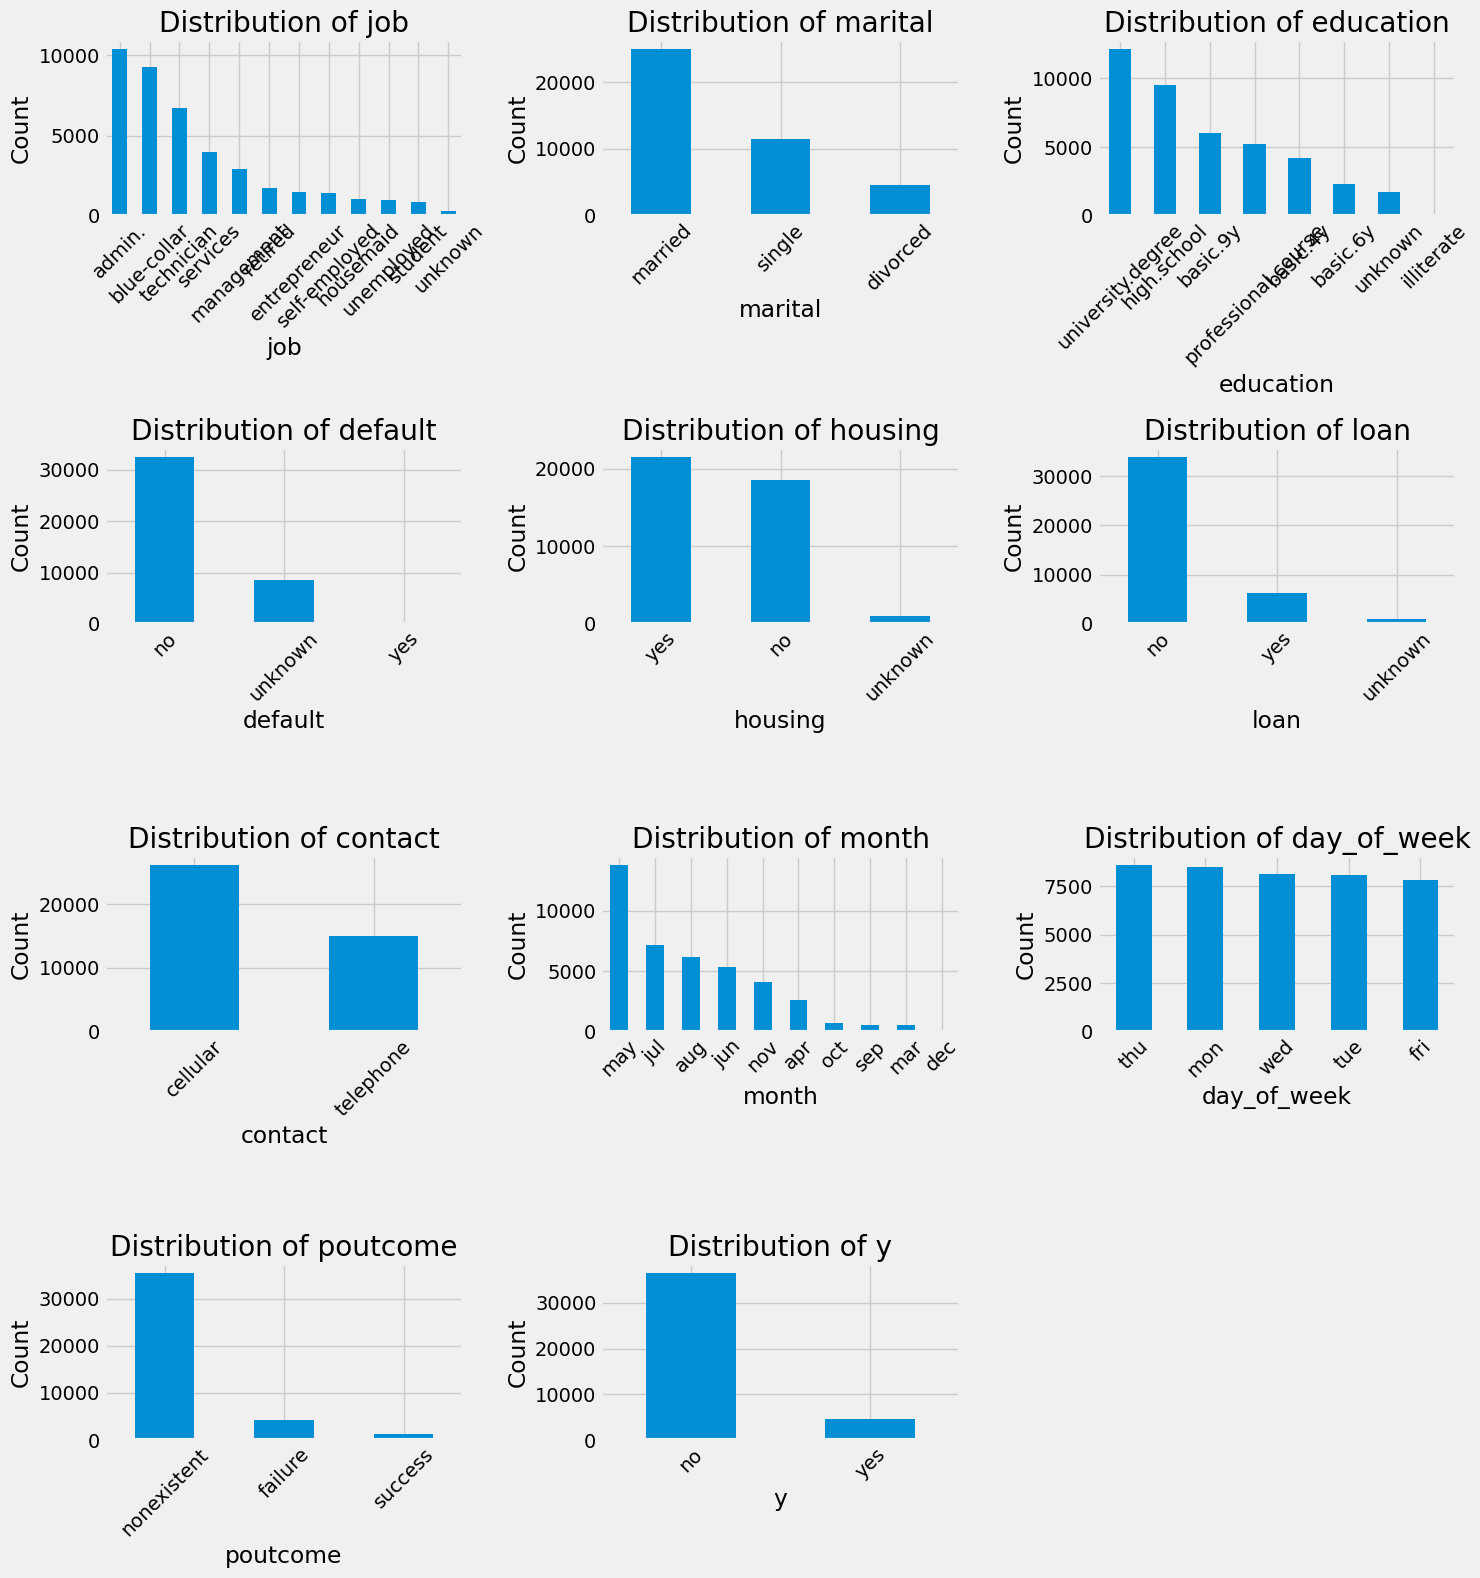

In [105]:
import math
# Select categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns

# Grid size (rows and cols)
n_cols = 3
n_rows = math.ceil(len(categorical_cols) / n_cols)

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))
axes = axes.flatten()

# Loop through categorical columns and plot
for i, col in enumerate(categorical_cols):
    df[col].value_counts().plot(kind='bar', ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_ylabel('Count')
    axes[i].set_xlabel(col)
    axes[i].tick_params(axis='x', rotation=45)

# Remove empty plots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

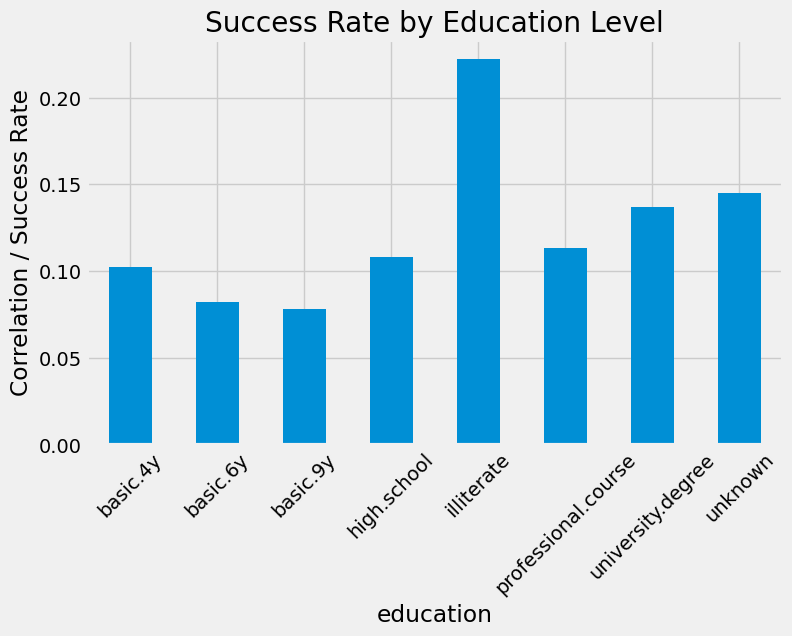

In [86]:
# check education and default
df['y_num'] = df['y'].map({'yes': 1, 'no': 0})
edu_corr = df.groupby('education')['y_num'].mean()

edu_corr.plot(kind='bar', figsize=(8,5))
plt.ylabel('Correlation / Success Rate')
plt.title('Success Rate by Education Level')
plt.xticks(rotation=45)
plt.show()

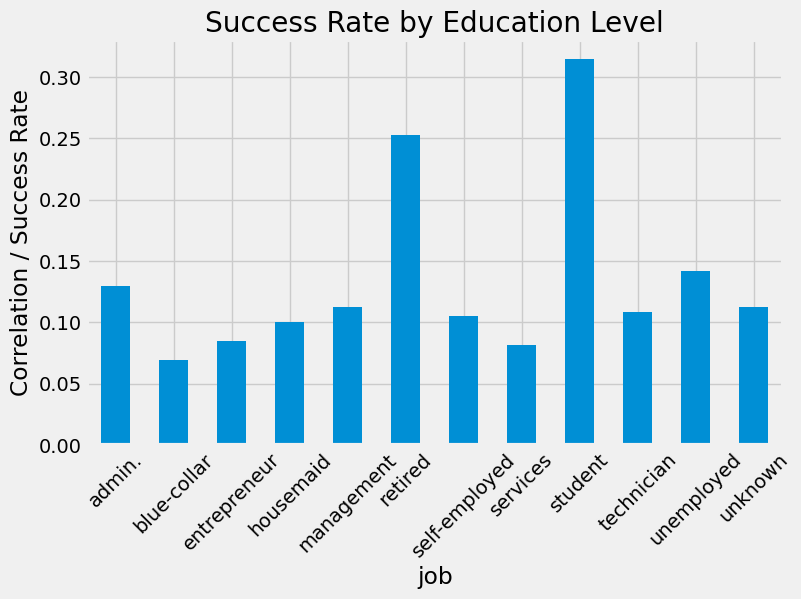

In [95]:
job_corr = df.groupby('job')['y_num'].mean()
job_corr.plot(kind='bar', figsize=(8,5))
plt.ylabel('Correlation / Success Rate')
plt.title('Success Rate by Education Level')
plt.xticks(rotation=45)
plt.show()

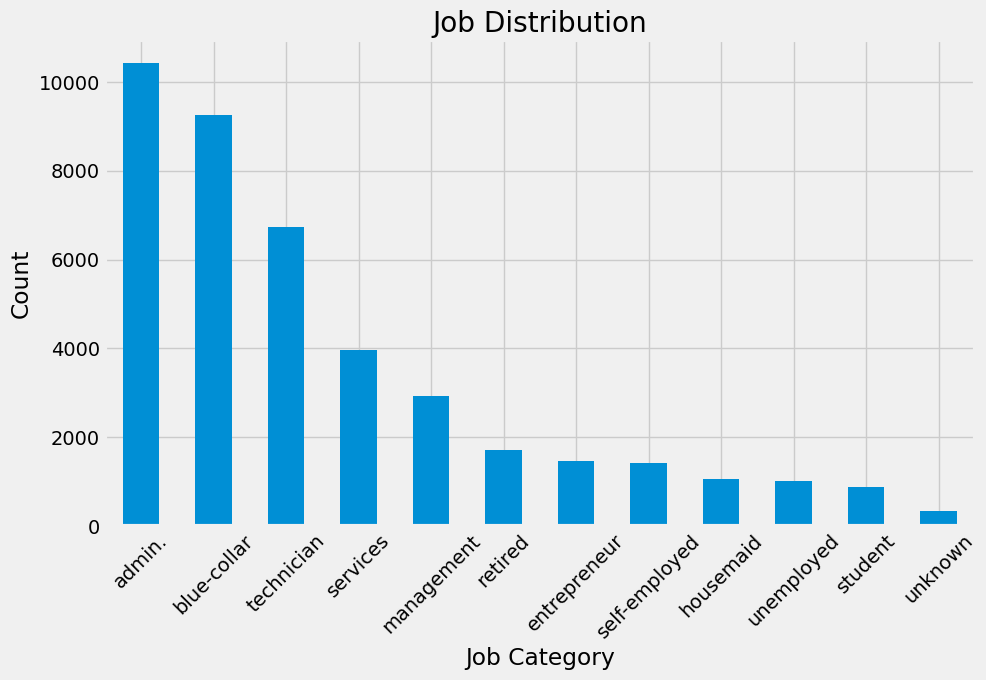

In [92]:
# check job categories
df['job'].value_counts().plot(kind='bar', figsize=(10, 6))

plt.title('Job Distribution')
plt.xlabel('Job Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

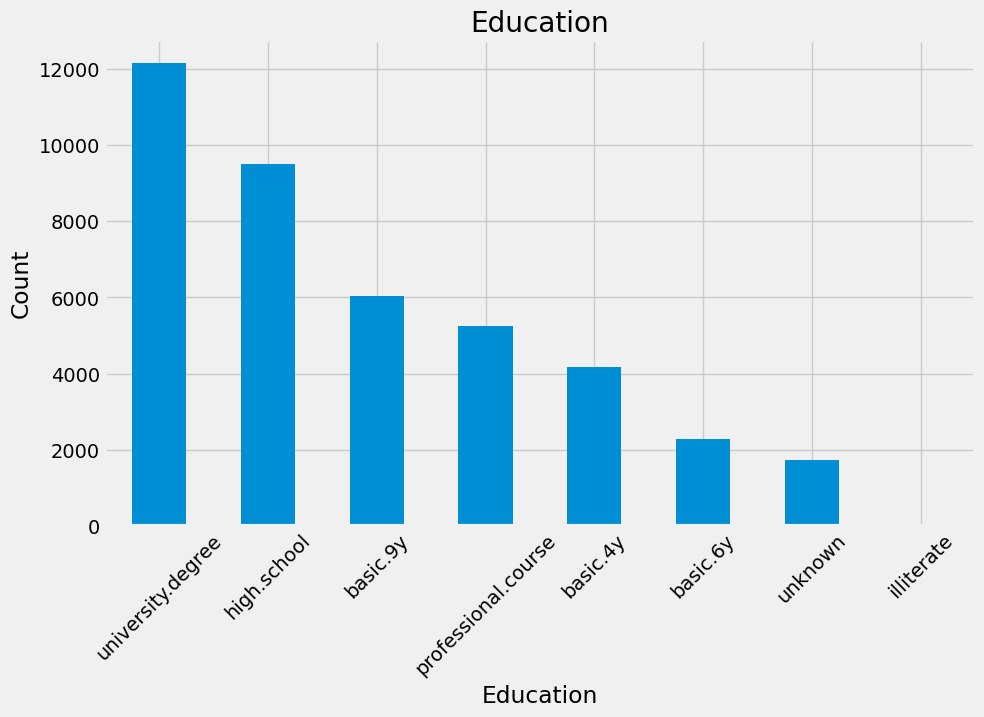

In [93]:
# check education categories
df['education'].value_counts().plot(kind='bar', figsize=(10, 6))

plt.title('Education')
plt.xlabel('Education')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [31]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import KNNImputer

# using KNN imputation for categorical
encoder = OrdinalEncoder()
df_encoded = df.copy()
categorical_cols = ["job", "marital", "education", "default", "housing", "loan"]
df_encoded[categorical_cols] = encoder.fit_transform(df_encoded[categorical_cols])

imputer = KNNImputer(n_neighbors=5)
df_imputed = pd.DataFrame(imputer.fit_transform(df_encoded), columns=df_encoded.columns)

df_imputed[categorical_cols] = encoder.inverse_transform(df_imputed[categorical_cols])


ValueError: could not convert string to float: 'telephone'

All modules loaded


### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

### Problem 9: Score the Model

What is the accuracy of your model?

### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

##### Questions